Goals of this notebook
---
* Inspect the open-loop trajectories of the system controlled (in open-loop) by different DDPC strategies (SPC, C-SPC, DeePC)
* Inspect the role played by the slack variable
* Inspect how peformances change as a function of $\lambda_2$

For more details about SPC, C-SPC, DeePC see 

On the equivalence of direct and indirect data-driven predictive control approaches   
_Per Mattsson, Fabio Bonassi, Valentina Breschi, Thomas B. Schön_  
Pre-print, 2024. [arXiv: 2403.05860](https://arxiv.org/abs/2403.05860)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

from gddpc.controller import Oracle, DDPC
from gddpc.testers import DistanceFromOracle, SplitQuadraticCriterion
from openloop_test import build_benchmark_system, run_openloop_tests

In [2]:
with open('default_campaign.yaml', 'r') as file:
    params = yaml.safe_load(file)
    benchmark_system = params.pop('benchmark_system')
    benchmark_params = params.pop('benchmark_params')
    ddpc_params = params.pop('ddpc_params')

    system = build_benchmark_system(benchmark_system, benchmark_params)

In [3]:
u_tr, y_tr = system.get_training_data(N_bar=params['N_bar'], random_seed=params['random_seed']*2)

Training set generated [N_bar = 1000]. SNR = [11.84149777]


In [4]:
# If ddpc_params['y_bound'] is None, set y_lb and y_ub to -np.inf and np.inf
y_bound = ddpc_params.pop('y_bound', None)
if y_bound is None:
    ddpc_params['y_lb'] = -np.inf
    ddpc_params['y_ub'] = np.inf
else:
    ddpc_params['y_lb'] = y_bound[0]
    ddpc_params['y_ub'] = y_bound[1]

In [5]:
# SPC: DDPC without slack variable and non-causal predictor
d_spc = DDPC(u_tr, y_tr, T=ddpc_params['T'], rho=ddpc_params['rho'], causal=False, solver=ddpc_params['solver'], name='SPC')
d_spc.mpc_setup(u_lb=system.u_bound[0], 
                u_ub=system.u_bound[1],
                y_lb=ddpc_params['y_lb'],
                y_ub=ddpc_params['y_ub'],
                Q=ddpc_params['Q'],
                R=ddpc_params['R'],
                S=ddpc_params['S'],
                slack_in_stage_cost=False,
                slack_in_constraint=False)

# C-SPC: DDPC without slack variable and causal predictor
d_cspc = DDPC(u_tr, y_tr, T=ddpc_params['T'], rho=ddpc_params['rho'], causal=True, solver=ddpc_params['solver'], name='C-SPC')
d_cspc.mpc_setup(u_lb=system.u_bound[0], 
                 u_ub=system.u_bound[1],
                 y_lb=ddpc_params['y_lb'],
                 y_ub=ddpc_params['y_ub'],
                 Q=ddpc_params['Q'],
                 R=ddpc_params['R'],
                 S=ddpc_params['S'],
                 slack_in_stage_cost=False, 
                slack_in_constraint=False)

controllers = [d_spc, d_cspc]

# DeePC
for lambda2 in params['slack_regs']:
    d_deepc = DDPC(u_tr, y_tr, T=ddpc_params['T'], rho=ddpc_params['rho'], solver=ddpc_params['solver'], name=f'DeePC-λ={lambda2}')
    d_deepc.mpc_setup(u_lb=system.u_bound[0], 
                      u_ub=system.u_bound[1],
                      y_lb=ddpc_params['y_lb'],
                      y_ub=ddpc_params['y_ub'],
                      Q=ddpc_params['Q'],
                      R=ddpc_params['R'],
                      S=ddpc_params['S'],
                      slack_in_stage_cost=True,
                      slack_in_constraint=True,
                      lambda2=lambda2)
    controllers.append(d_deepc)


# The oracle has access to the actual system dynamics
d_oracle = Oracle(system.sys, T=ddpc_params['T'], solver=ddpc_params['solver'], name='Oracle')
d_oracle.mpc_setup(u_lb=system.u_bound[0], 
                   u_ub=system.u_bound[1],
                   y_lb=ddpc_params['y_lb'],
                   y_ub=ddpc_params['y_ub'],
                   Q=ddpc_params['Q'],
                   R=ddpc_params['R'],
                   S=ddpc_params['S'],)

# Make sure that Q and R are as expected
Q = ddpc_params['Q'] if isinstance(ddpc_params['Q'], np.ndarray) else ddpc_params['Q'] * np.eye(system.n_out)
R = ddpc_params['R'] if isinstance(ddpc_params['R'], np.ndarray) else ddpc_params['R'] * np.eye(system.n_in)

# Criteria
criterion = SplitQuadraticCriterion(Q, R)
distance_criterion = DistanceFromOracle(Q, R)

Testing the predictors
---
In this section, we inspect the predictive performances of the multi-step predictors of SPC and C-SPC.

The data used for validation is the following
* The context window $z = [ u_{t-\rho}^\prime, ..., u_{t-1}^\prime, y_{t-\rho}^\prime, ..., y_{t-1}^\prime ]$ is generated applying a Gaussian excitation with std `system.exc_u_std`. The output is also corrupted by white Gaussian noise with std `system.noise_y_std`
* After $t=\rho$, we apply a constant input $u_{t+k} = \bar{u} = 1$. Measurement noise is not shown in the plots to have a better grasp of the predictive performances. 

In [6]:
# Let's plot the openl-loop predictions of SPC and C-SPC, just to inspect them
# Data used for validation:
# - In the context window u is Gaussian with std system.exc_u_std, and y has measurement noise
# - After t=rho, we apply a constant input u_bias=1 and we return the noise-free output 
u_cxt, y_cxt, u_val, y_val = system.get_test_data_with_context(ddpc_params['T'], 
                                                               ddpc_params['rho'], 
                                                               u_bias=1.0, 
                                                               exc_u_std=0.0,
                                                               random_seed=params['random_seed']*3)

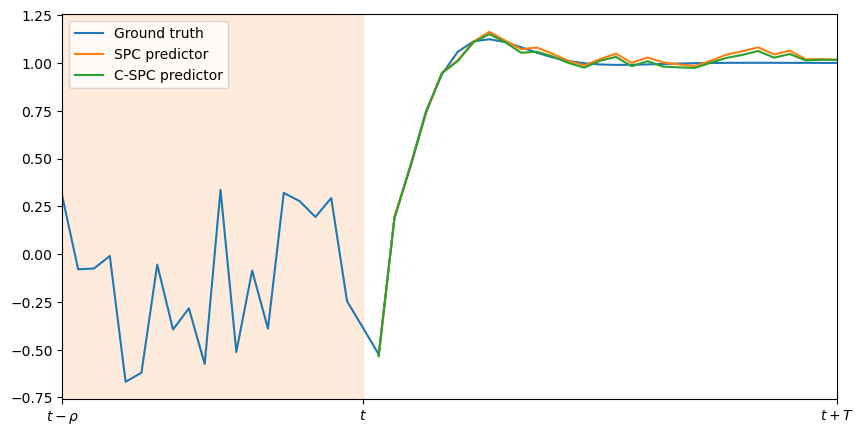

In [7]:
y_acausal = d_spc.predict(u_cxt, y_cxt, u_val)
y_causal = d_cspc.predict(u_cxt, y_cxt, u_val)
t_val = np.arange(ddpc_params['rho'], ddpc_params['T']+ddpc_params['rho'])

t_gt = np.arange(0, ddpc_params['T'] + ddpc_params['rho'])
y_gt = np.concatenate([y_cxt, y_val])

plt.figure(figsize=(10, 5))
plt.axvspan(0, ddpc_params['rho'] -1, color='tab:orange', alpha=0.15)
plt.plot(t_gt, y_gt, label='Ground truth')
plt.plot(t_val, y_acausal, label='SPC predictor')
plt.plot(t_val, y_causal, label='C-SPC predictor')
plt.xlim(0, ddpc_params['T'] + ddpc_params['rho'] -1 )
plt.xticks(ticks=[0, ddpc_params['rho'] - 1, ddpc_params['T']+ddpc_params['rho']-1], labels=[r'$t-\rho$', '$t$', '$t+T$'])
plt.legend()

Testing the open-loop DDPC control sequence
---
We consider the system at rest at $x_0 = 0$. Over the first $\rho$ time-steps, no input is applied ($u_{t-\rho} = ... = u_{t-1} = 0$), and the output is corrupted by measurement noise.
The task of the DDPC is to generate a control sequence $u_t, ..., u_{t+T}$ that minimizes the quadratic cost function
$$J = \sum_{k=0}^{T} \| \hat{y}_{t+k} - \bar{y} \|_Q^2 +  \| u_{t+k} \|_R^2$$

Let's denote $\pmb{\textrm{u}} = [u_t^\prime, ..., u_{t+T}^\prime ]^\prime$ and $\pmb{\textrm{y}} = [y_t^\prime, ..., y_{t+T}^\prime ]^\prime$. Then the SPC predictor is
$$\hat{\pmb{\textrm{y}}} = \hat{\Theta} \begin{bmatrix} \pmb{\textrm{z}} \\ \pmb{\textrm{u}}  \end{bmatrix} := \hat{\pmb{\textrm{y}}}_m$$
In DeePC, instead, the predictor is 
$$\hat{\pmb{\textrm{y}}} = \hat{\Theta} \begin{bmatrix} \pmb{\textrm{z}} \\ \pmb{\textrm{u}}  \end{bmatrix} + \pmb{Δ \hat{\textrm{y}}} = \hat{\pmb{\textrm{y}}}_m + \pmb{Δ \hat{\textrm{y}}}$$

In [8]:
# We consider the case where we are at the origing and we want to track the reference
x0 = np.zeros((system.sys.A.shape[0],))
u_ctx, y_ctx, xf = system.get_online_context(ddpc_params['rho'], 
                                             x0, 
                                             random_seed=params['random_seed'],
                                             exc_u_std=0.0)
ref = ddpc_params['ref']


In [9]:
_ = d_oracle.mpc_step(reference=ref, x0=xf)

for d in controllers:
    _ = d.mpc_step(reference=ref, Up=u_ctx, Yp=y_ctx)

/opt/homebrew/Caskroom/mambaforge/base/envs/PT/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:226: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(DPP_ERROR_MSG)


Open-loop trajectories
------
To highlight the effect of the output slack in DeePC, we plot both $\hat{\pmb{\textrm{y}}}_m = \hat{\Theta} \pmb{\textrm{u}}$ and $\hat{\pmb{\textrm{y}}} = \hat{\pmb{\textrm{y}}}_m + \pmb{\Delta \hat{\textrm{y}}}$.

Sometimes for DeePC we might refer to $\hat{\pmb{\textrm{y}}}$ as _slacked output prediction_. Note that for SPC, $\hat{\pmb{\textrm{y}}} = \hat{\pmb{\textrm{y}}}_m$.


In [10]:
# Get the system output when subject to the DDPC control sequence
y_oracle = system.forced_motion(d_oracle._u.value, x0=xf, noise_y_std=0.0)[0]
t = np.arange(0, ddpc_params['T'] + ddpc_params['rho']) 
t_control = np.arange(ddpc_params['rho']-1, ddpc_params['T']+ddpc_params['rho'])

In [11]:
def concat_last_output(y, y_ctx):
    return np.concatenate([y_ctx[-1].reshape(1, -1), y])

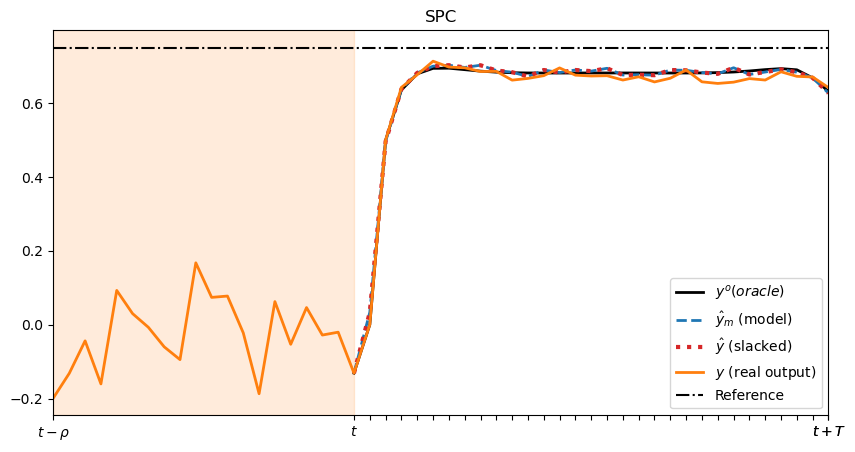

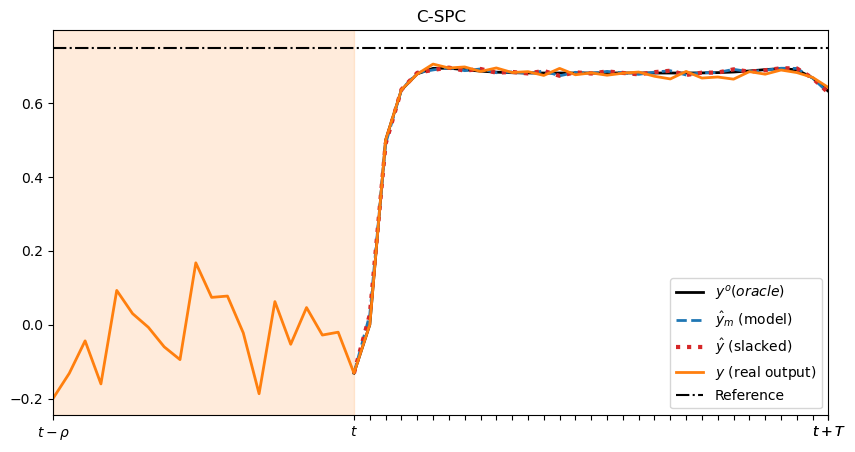

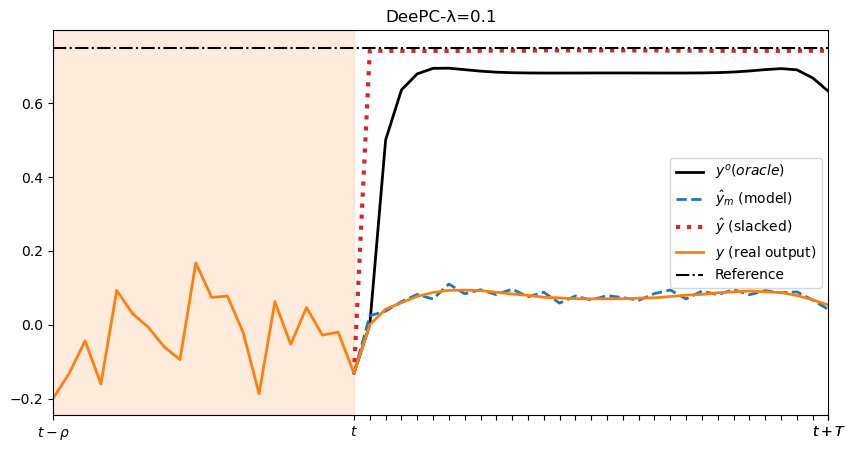

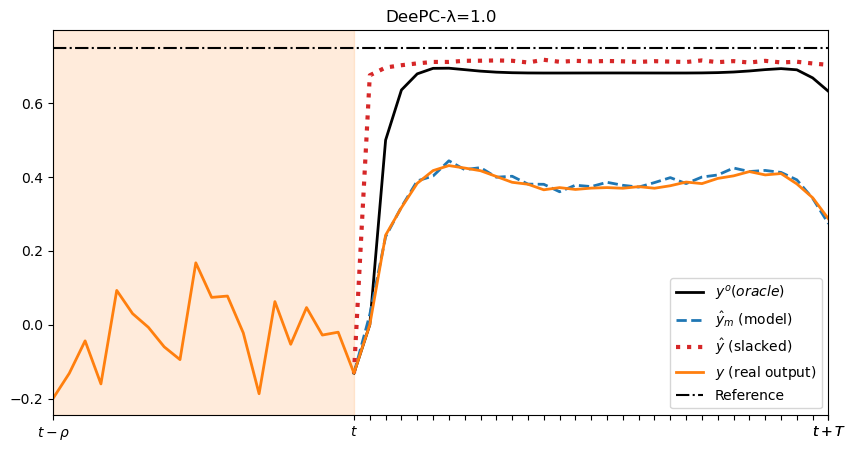

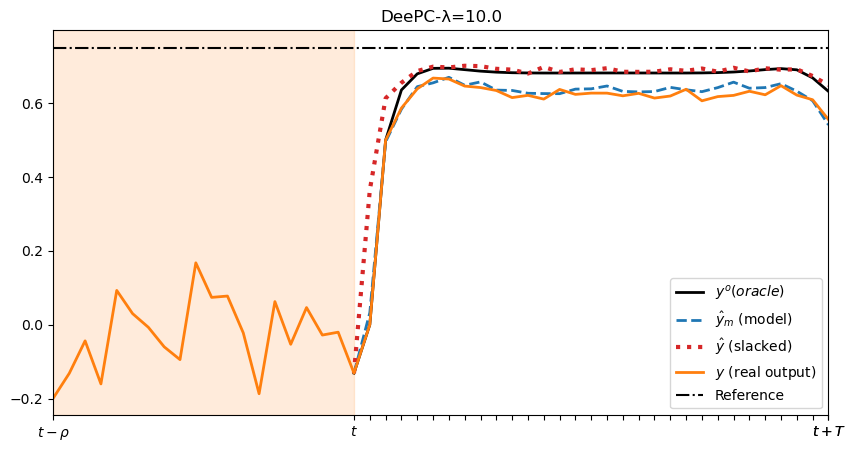

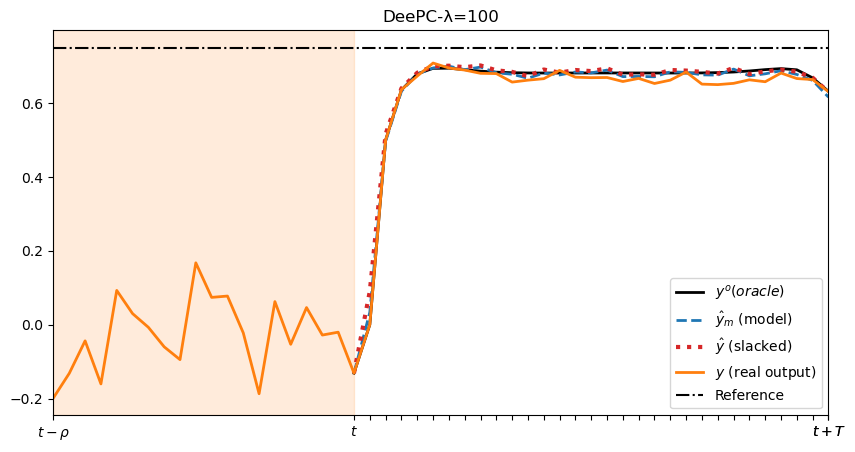

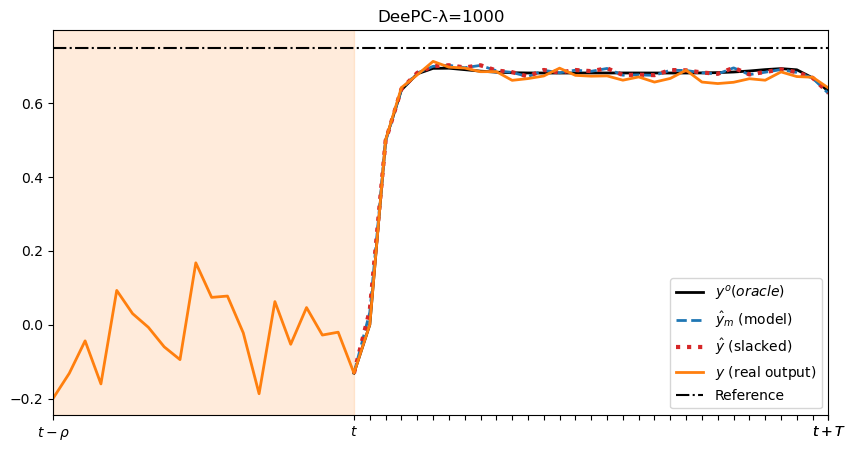

In [12]:
for d in controllers:
    y_resp = system.forced_motion(d._u.value, x0=xf, noise_y_std=0.0)[0]

    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(t_control, concat_last_output(y_oracle, y_ctx), label='${y}^o (oracle)$', color='black', linewidth=2)
    ax.plot(t_control, concat_last_output(d._ym.value, y_ctx), label='$\hat{y}_m$ (model)', color='tab:blue', linestyle='--', linewidth=2)
    ax.plot(t_control, concat_last_output(d._y.value, y_ctx), label='$\hat{y}$ (slacked)', color='tab:red', linestyle=':', linewidth=3)
    ax.plot(t, np.concatenate([y_ctx, y_resp]), label='$y$ (real output)', color='tab:orange', linewidth=2)
    ax.plot([t[0], t[-1]], [ref, ref], label='Reference', color='black', linestyle='-.', linewidth=1.5)
    ax.legend()
    ax.set_title(d.name)
    ax.axvspan(0, ddpc_params['rho'] -1 , color='tab:orange', alpha=0.15)
    ax.set_xlim(0, ddpc_params['T'] + ddpc_params['rho'] -1)
    x_ticks = [0, ddpc_params['rho'] - 1] + list(range(ddpc_params['rho'], ddpc_params['T']+ddpc_params['rho'])) + [ddpc_params['T']+ddpc_params['rho']-1]
    x_ticks_labels = [r'$t-\rho$', '$t$'] + list(['' for _ in range(ddpc_params['T'])]) + ['$t+T$']
    ax.set_xticks(ticks=x_ticks, labels=x_ticks_labels)



Usage of slack variable
---
In the figures above, it can be seen that if $\lambda_2$ is not large enough, the slack can be used to reduce the output tracking penalty, see (Mattsson, Bonassi, Breschi, Schön, 2024) Corollary 1.

Thus, DeePC minimizes the reweighted criterion 
$$J = \sum_{k=0}^{T} \| \hat{y}_{t+k} - \bar{y} \|_{\tilde{Q}}^2 +  \| u_{t+k} \|_R^2$$
with $\tilde{Q}= Q - Q (Q + \frac{\lambda_2}{N} \Sigma_\Delta^{-1})^{-1}Q ≺ Q$. This mechanism implicitly encourages parsimony in the control variable, at the price of unsatisfactory tracking performance.

Let us consider, for example, the case of DeePC with $\lambda_2 = 1$. From the figure above it is evident that the slack variable $\pmb{\Delta \hat{\textrm{y}}}$ is used to adjust the predictions so that $\pmb{\hat{\textrm{y}}} \approx \bar{y}$ while decreasing, at the same time, the control variable. 
However, when we apply the control sequence to the actual system the tracking performances turn out to be unsatisfactory.

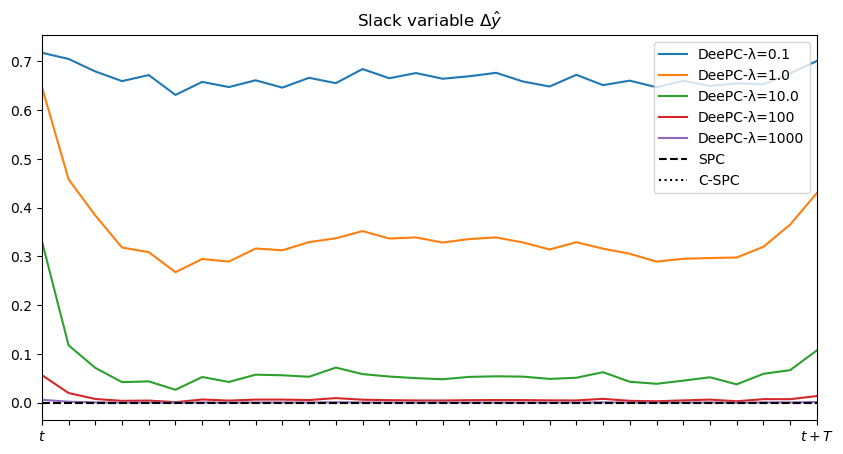

In [13]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

for d in controllers[2:]:
    ax.plot(d._delta.value, label=d.name)

ax.plot(d_spc._delta.value, label=d_spc.name, linestyle='--', color='black')
ax.plot(d_cspc._delta.value, label=d_cspc.name, linestyle=':', color='black')

ax.legend()
ax.set_title('Slack variable $\Delta\hat{y}$')
ax.set_xlim(0, ddpc_params['T'] -1)
x_ticks = list(range(ddpc_params['T']))
x_ticks_labels = ['$t$'] + list(['' for i in range(ddpc_params['T'] - 2)]) + ['$t+T$'] 
_ = ax.set_xticks(ticks=x_ticks, labels=x_ticks_labels)

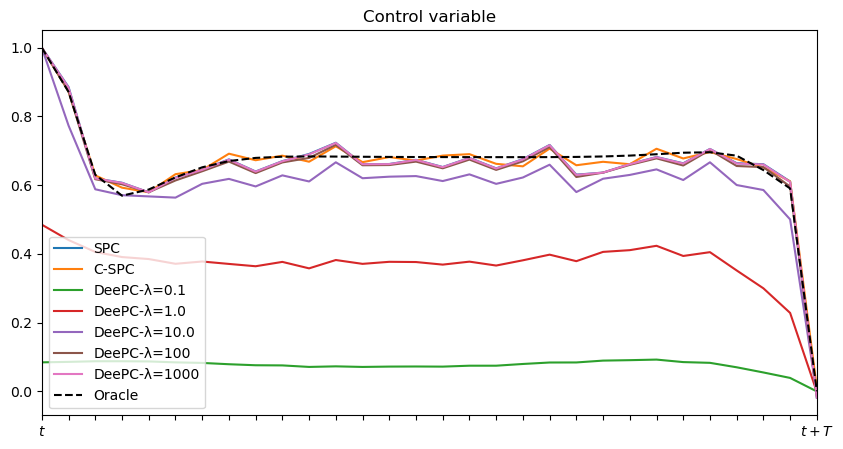

In [14]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

for d in controllers:
    ax.plot(d._u.value, label=d.name)

ax.plot(d_oracle._u.value, label=d_oracle.name, linestyle='--', color='black')

ax.legend()
ax.set_title('Control variable')
ax.set_xlim(0, ddpc_params['T'] -1)
x_ticks = list(range(ddpc_params['T']))
x_ticks_labels = ['$t$'] + list(['' for i in range(ddpc_params['T'] - 2)]) + ['$t+T$'] 
_ = ax.set_xticks(ticks=x_ticks, labels=x_ticks_labels)

More tests
---
The plots above refer to a single sample of the $z$ context data. Can we get similar results when we use many realizations of the context data?

To make our work easier, we can use the `run_openloop_tests` function of `openloop_test.py`.
* We still consider the same number of training data, `N_bar`.
* `Niter = 100` represent the number of random realizations of the context data over which we evaluate the performances of the DDPCs.
* We consider more values of $\lambda_2$ top get a smoother curve. 

_Note: running the following cell might take few minutes!_

Training set generated [N_bar = 1000]. SNR = [11.28366272]


/opt/homebrew/Caskroom/mambaforge/base/envs/PT/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:226: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(DPP_ERROR_MSG)


   Controller    E[J_tr]   E[J_co]  E[Delta_tr]  E[Delta_co]  E[violations]  \
0         SPC   0.827045  1.326238     0.010580     0.002567            0.0   
1       C-SPC   0.847133  1.308656     0.013235     0.002418            0.0   
2       DeePC  13.917229  0.015154    10.565028     1.104478            0.0   
3       DeePC   5.002653  0.386884     2.868814     0.309067            0.0   
4       DeePC   1.150544  1.132076     0.127030     0.015351            0.0   
5       DeePC   0.855398  1.303678     0.015846     0.003093            0.0   
6       DeePC   0.829828  1.323940     0.011023     0.002609            0.0   
7       DeePC  10.896070  0.069840     7.885070     0.830416            0.0   
8       DeePC   2.487281  0.735212     0.941747     0.103090            0.0   
9       DeePC   0.946530  1.240915     0.041440     0.005869            0.0   
10      DeePC   0.838252  1.317101     0.012468     0.002749            0.0   
11      DeePC   0.828156  1.325318     0.010755     

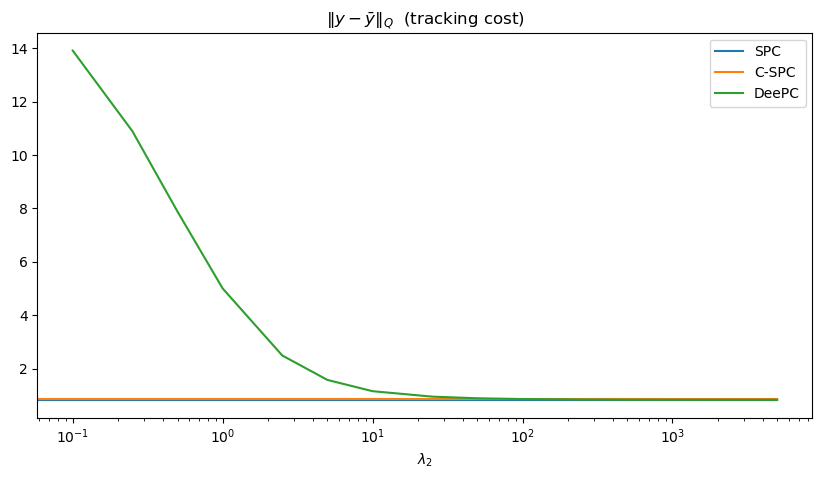

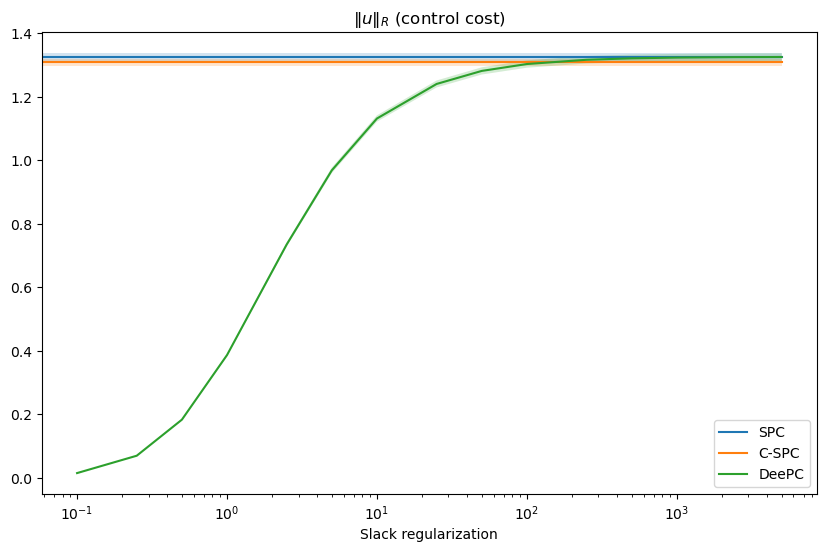

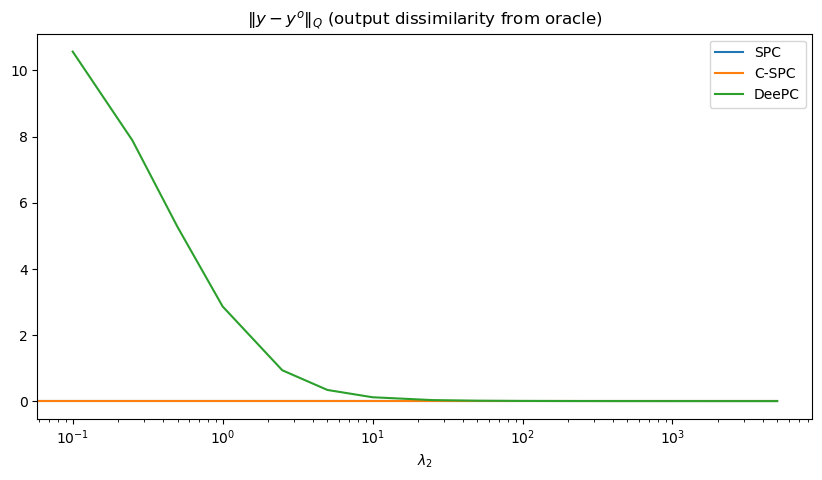

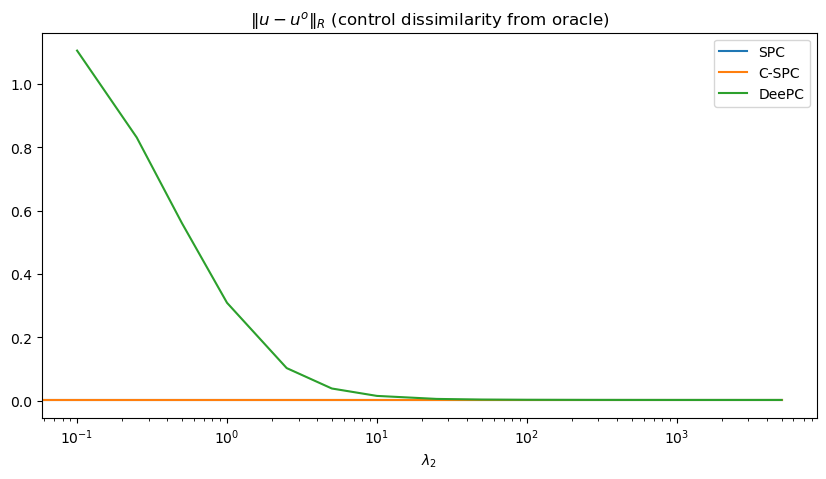

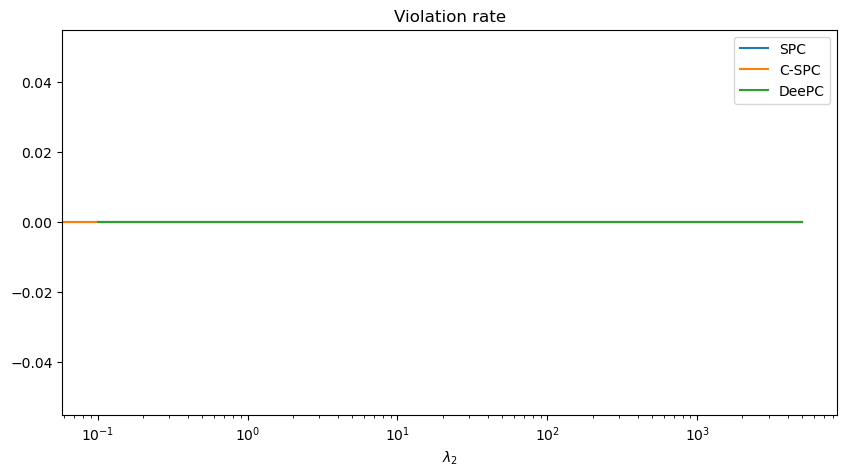

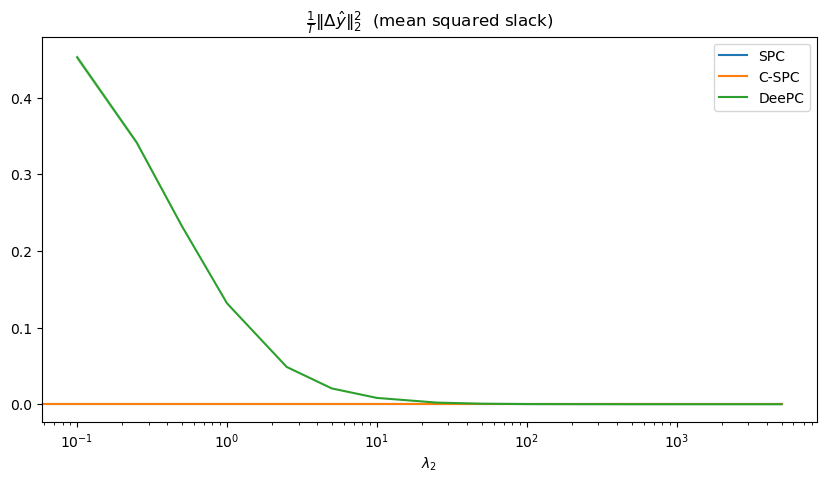

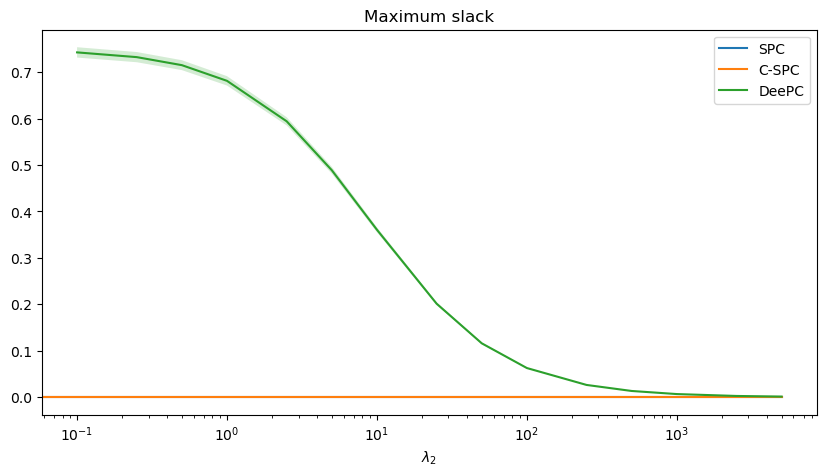

,Controller,E[J_tr],E[J_co],E[Delta_tr],E[Delta_co],E[violations],E[slack_mse],E[slack_max],std[J_tr],std[J_co],std[Delta_tr],std[Delta_co],std[violations],std[slack_mse],std[slack_max],lambda
0,SPC,0.827045,1.326238,0.010580,0.002567,0.0,0.000000e+00,0.000000,0.015071,0.011804,0.003421,0.000752,0.0,0.000000e+00,0.000000,inf
1,C-SPC,0.847133,1.308656,0.013235,0.002418,0.0,0.000000e+00,0.000000,0.015623,0.011604,0.003903,0.000668,0.0,0.000000e+00,0.000000,inf
2,DeePC,13.917229,0.015154,10.565028,1.104478,0.0,4.526937e-01,0.742573,0.012588,0.000135,0.011282,0.001148,0.0,3.893657e-03,0.011129,0.10
3,DeePC,5.002653,0.386884,2.868814,0.309067,0.0,1.316508e-01,0.681291,0.036750,0.003475,0.029999,0.003126,0.0,1.109256e-03,0.010124,1.00
4,DeePC,1.150544,1.132076,0.127030,0.015351,0.0,8.213092e-03,0.360606,0.022228,0.009986,0.011101,0.001208,0.0,1.386258e-04,0.005332,10.00
5,DeePC,0.855398,1.303678,0.015846,0.003093,0.0,1.889697e-04,0.062835,0.015908,0.011587,0.004270,0.000755,0.0,4.201628e-06,0.000935,100.00
6,DeePC,0.829828,1.323940,0.011023,0.002609,0.0,2.146404e-06,0.006789,0.015156,0.011782,0.003505,0.000752,0.0,4.912732e-08,0.000101,1000.00
7,DeePC,10.896070,0.069840,7.885070,0.830416,0.0,3.413190e-01,0.732372,0.023948,0.000628,0.021107,0.002160,0.0,2.908332e-03,0.010978,0.25
8,DeePC,2.487281,0.735212,0.941747,0.103090,0.0,4.864024e-02,0.594184,0.033317,0.006631,0.023925,0.002521,0.0,4.677938e-04,0.008803,2.50
9,DeePC,0.946530,1.240915,0.041440,0.005869,0.0,2.130694e-03,0.201446,0.018207,0.010969,0.006764,0.000857,0.0,4.312564e-05,0.002991,25.00


In [15]:
lambda2 = params['slack_regs'] + [2.5 * l for l in  params['slack_regs']] + [5 * l for l in  params['slack_regs']]

plot_opts = {'yscale': 'linear',
             'figsize': (10, 5),
             'slack_label': '$\lambda_2$',
             'J_tr_title': r'$\| y - \bar{y} \|_Q$  (tracking cost)',
             'J_co_title': '$\| u \|_R$ (control cost)',
             'Delta_tr_title': r'$\| y - y^o \|_Q$ (output dissimilarity from oracle)',
             'Delta_co_title': r'$\| u - u^o \|_R$ (control dissimilarity from oracle)', 
             'violation_title': 'Violation rate',
             'slack_ms_title': r'$\frac{1}{T} \| Δ \hat{y} \|_2^2$  (mean squared slack)',
             'slack_max_label': r'$\max \lvert Δ y \lvert$ (max slack)'
             }

run_openloop_tests(N_bar=params['N_bar'],
                   random_seed=params['random_seed']+200, # Use a new seed
                   Niter=100,
                   slack_regs=lambda2,
                   ddpc_params=ddpc_params, 
                   system=system,
                   plot_opts=plot_opts)